## TFIDF First Simple Model
Logistic Regression out of the box, n-grams=1

In [78]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import re

import warnings
warnings.filterwarnings('ignore')

In [106]:
df = pd.read_csv('../data/processed_text.csv')
df.head()

,Grade,Text,lemmatized,grammarized
0,1.0,I had just gone to Chobot Space and Science Ce...,i have just go to chobot space and science cen...,I had just gone to + chobot + space and + scie...
1,1.0,My cat is fluffy. His name is Buzz. He is my f...,my cat be fluffy his name be buzz he be my fav...,+ my cat is fluffy . + his name is + buzz . + ...
2,1.0,Spring is sweet because we can go boat riding ...,spring be sweet because we can go boat riding ...,+ spring is sweet because we can go boat ridin...
3,1.0,One day baby Josh came home. He was in a yello...,one day baby josh come home he be in a yellow ...,+ one day baby + josh came home . + he was in ...
4,1.0,One time I went to Mexico. It was a blast! I m...,one time i go to mexico it be a blast i meet p...,+ one time I went to + mexico . + it was a bla...


In [56]:
def assess_model(model, scores, X_train, y_train, ngram_range=(1,3)):
    for ngram in range(ngram_range[0],ngram_range[1]+1):
        lr_count_pipe = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,ngram))),
                                  ('logreg', model)])

        lemma_scores = cross_val_score(lr_count_pipe, X_train['lemmatized'],y_train, cv=3, 
                                       scoring='neg_mean_absolute_error')
        grammar_scores = cross_val_score(lr_count_pipe, X_train['grammarized'], y_train, cv=3, 
                                         scoring='neg_mean_absolute_error')
        scores = scores.append({'model':type(model).__name__,
                        'encoding':'Count Vectors',
                        'ngram':ngram,
                       'lemmas':-np.mean(lemma_scores),
                      'grammar':-np.mean(grammar_scores)},
                      ignore_index=True)

        lr_tfidf_pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1,ngram))),
                              ('logreg', model)])
        lemma_scores = cross_val_score(lr_tfidf_pipe, X_train['lemmatized'],y_train, cv=3, 
                                       scoring='neg_mean_absolute_error')
        grammar_scores = cross_val_score(lr_tfidf_pipe, X_train['grammarized'], y_train, cv=3, 
                                         scoring='neg_mean_absolute_error')

        scores = scores.append({'model':type(model).__name__,
                        'encoding':'TF-IDF Vectors',
                        'ngram':ngram,
                       'lemmas':-np.mean(lemma_scores),
                      'grammar':-np.mean(grammar_scores)},
                      ignore_index=True)
        print('finished ngram', ngram)
        
    return scores
                 

In [60]:
X = df[['lemmatized', 'grammarized']]
y = df.Grade
## Split lemma train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=11)
scores = pd.DataFrame(columns = ['model','encoding','lemmas','grammar'])

In [61]:
scores = assess_model(LinearRegression(), scores, X_train, y_train, ngram_range=(1,3))

finished ngram 1
finished ngram 2
finished ngram 3


In [62]:
scores = assess_model(DecisionTreeRegressor(), scores, X_train, y_train, ngram_range=(1,3))

finished ngram 1
finished ngram 2
finished ngram 3


In [65]:
scores = assess_model(RandomForestRegressor(), scores, X_train, y_train, ngram_range=(1,3))

finished ngram 1
finished ngram 2
finished ngram 3


In [66]:
scores.sort_values(by=['lemmas','grammar'])

,model,encoding,lemmas,grammar,ngram
12,RandomForestRegressor,Count Vectors,1.327574,1.298095,1.0
16,RandomForestRegressor,Count Vectors,1.333105,1.313914,3.0
14,RandomForestRegressor,Count Vectors,1.344008,1.346999,2.0
1,LinearRegression,TF-IDF Vectors,1.370492,1.376917,1.0
13,RandomForestRegressor,TF-IDF Vectors,1.488141,1.453934,1.0
15,RandomForestRegressor,TF-IDF Vectors,1.532441,1.544971,2.0
3,LinearRegression,TF-IDF Vectors,1.578731,1.627360,2.0
17,RandomForestRegressor,TF-IDF Vectors,1.605158,1.610830,3.0
8,DecisionTreeRegressor,Count Vectors,1.775669,1.718519,2.0
10,DecisionTreeRegressor,Count Vectors,1.800154,1.688735,3.0


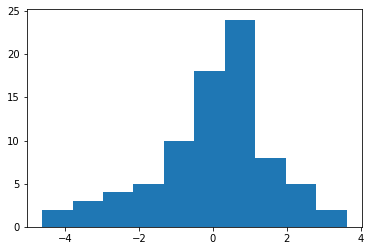

In [79]:
model = RandomForestRegressor()
rf_count_pipe = Pipeline([('vectorizer', CountVectorizer()),
                      ('RFreg', model)])
rf_count_pipe.fit(X_train['grammarized'], y_train)
yhat = rf_count_pipe.predict(X_test['grammarized'])
plt.hist(yhat - y_test)
plt.show()

In [ ]:
RandomForestRegressor()

In [85]:
rf_count_pipe = Pipeline([('vectorizer', CountVectorizer()),
                      ('RFreg', model)])
param_grid = [{'RFreg__n_estimators':[100,200,300],
              'RFreg__max_depth':[4,6,None],
              }]
clf = GridSearchCV(rf_count_pipe,
                  param_grid, scoring='neg_mean_absolute_error')
clf.fit(X_train.grammarized, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('RFreg', RandomForestRegressor())]),
             param_grid=[{'RFreg__max_depth': [4, 6, None],
                          'RFreg__n_estimators': [100, 200, 300]}],
             scoring='neg_mean_absolute_error')

In [88]:
print(clf.best_score_)
print(clf.best_params_)

{'RFreg__max_depth': None, 'RFreg__n_estimators': 300}

In [89]:
rf_count_pipe = Pipeline([('vectorizer', CountVectorizer()),
                      ('RFreg', model)])
param_grid = [{'RFreg__n_estimators':[300,400,500],
              'RFreg__max_depth':[None],
              }]
clf = GridSearchCV(rf_count_pipe,
                  param_grid, scoring='neg_mean_absolute_error')
clf.fit(X_train.grammarized, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('RFreg', RandomForestRegressor())]),
             param_grid=[{'RFreg__max_depth': [None],
                          'RFreg__n_estimators': [300, 400, 500]}],
             scoring='neg_mean_absolute_error')

In [90]:
print(clf.best_score_)
print(clf.best_params_)

-1.2663993197278913
{'RFreg__max_depth': None, 'RFreg__n_estimators': 500}


In [91]:
rf_count_pipe = Pipeline([('vectorizer', CountVectorizer()),
                      ('RFreg', model)])
param_grid = [{'RFreg__n_estimators':[500,1000],
              'RFreg__max_depth':[None],
              }]
clf = GridSearchCV(rf_count_pipe,
                  param_grid, scoring='neg_mean_absolute_error')
clf.fit(X_train.grammarized, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('RFreg', RandomForestRegressor())]),
             param_grid=[{'RFreg__max_depth': [None],
                          'RFreg__n_estimators': [500, 1000]}],
             scoring='neg_mean_absolute_error')

In [92]:
print(clf.best_score_)
print(clf.best_params_)

-1.2636130952380953
{'RFreg__max_depth': None, 'RFreg__n_estimators': 500}


In [131]:
model = clf.best_estimator_
model.fit(df.grammarized, df.Grade)
yhat = model.predict(df['grammarized'])
print(np.abs(df.Grade - yhat).mean())

0.45313664596273306


In [127]:
model

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('RFreg', RandomForestRegressor(n_estimators=500))])

In [98]:
# import pickle
# pickle.dump(model, open('best_model.pkl','wb'))

In [128]:
model = pickle.load(open('best_model.pkl','rb'))
model.predict([df.grammarized[45]])

array([4.128])

In [129]:
df.Grade[45]

4.0